In [49]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
from jax.scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [3]:
d = pd.read_csv('data/chimpanzees.csv', sep=';')

In [4]:
d.sample(5)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
426,6,4.0,1,6,61,0,0,1
434,7,NaN,0,1,5,0,1,0
480,7,5.0,1,3,26,0,0,1
406,6,4.0,1,2,21,1,1,1
228,4,NaN,0,3,25,1,0,0


In [5]:
d.actor.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [15]:
d.describe()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
count,504.000000,252.00000,504.000000,504.000000,504.000000,504.000000,504.00000,504.000000
mean,4.000000,5.00000,0.500000,3.500000,36.500000,0.500000,0.56746,0.579365
std,2.001987,2.00398,0.500497,1.709522,20.803253,0.500497,0.49592,0.494151
min,1.000000,2.00000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000
25%,2.000000,3.00000,0.000000,2.000000,18.750000,0.000000,0.00000,0.000000
50%,4.000000,5.00000,0.500000,3.500000,36.500000,0.500000,1.00000,1.000000
75%,6.000000,7.00000,1.000000,5.000000,54.250000,1.000000,1.00000,1.000000
max,7.000000,8.00000,1.000000,6.000000,72.000000,1.000000,1.00000,1.000000


In [17]:
def model(actor, condition, prosoc_left, pulled_left):
    num_conditions = len(np.unique(condition))
    num_actors = len(np.unique(actor))

    #alpha = numpyro.sample('alpha', dist.Normal(0,1))
    alpha_actor = numpyro.sample('alpha_actor', dist.Normal(0,1.5).expand([num_actors,]))
    beta = numpyro.sample('beta', dist.Normal(0,0.5).expand([num_conditions, 2]))
    l = alpha_actor[actor] + beta[condition, prosoc_left]
    obs = numpyro.sample('obs', dist.BernoulliLogits(l), obs=pulled_left)


m11_1 = MCMC(NUTS(model), num_warmup=2000, num_samples=10000)
m11_1.run(random.PRNGKey(42), d.actor.values-1, d.condition.values, d.prosoc_left.values, d.pulled_left.values)
m11_1.print_summary()


sample: 100%|██████████| 12000/12000 [00:06<00:00, 1995.67it/s, 7 steps of size 4.26e-01. acc. prob=0.91]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_actor[0]     -0.44      0.33     -0.43     -0.98      0.11   2981.42      1.00
alpha_actor[1]      3.90      0.75      3.85      2.63      5.05   7967.28      1.00
alpha_actor[2]     -0.74      0.34     -0.73     -1.29     -0.19   3073.01      1.00
alpha_actor[3]     -0.74      0.34     -0.74     -1.28     -0.17   3036.30      1.00
alpha_actor[4]     -0.44      0.33     -0.43     -0.97      0.11   2988.23      1.00
alpha_actor[5]      0.49      0.33      0.48     -0.05      1.04   3056.73      1.00
alpha_actor[6]      1.97      0.42      1.96      1.29      2.67   4199.00      1.00
     beta[0,0]     -0.05      0.28     -0.05     -0.51      0.43   2585.59      1.00
     beta[0,1]      0.47      0.29      0.47      0.00      0.94   2595.29      1.00
     beta[1,0]     -0.40      0.29     -0.39     -0.86      0.09   2719.74      1.00
     beta[1,1]      0.36      0.28      0.36     -0.10      0.82

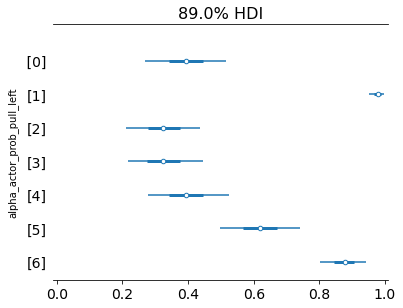

In [26]:
post = m11_1.get_samples(group_by_chain=True)
p_left = expit(post["alpha_actor"])
az.plot_forest({" ": p_left}, combined=True, hdi_prob=0.89)
plt.gca().set(xlim=(-0.01, 1.01))
plt.gca().set_ylabel(ylabel ='alpha_actor_prob_pull_left', rotation='vertical')
plt.show()

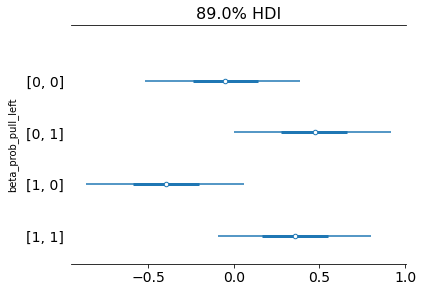

In [36]:
p_left = post["beta"]
az.plot_forest({" ": p_left}, combined=True, hdi_prob=0.89)
plt.gca().set_ylabel(ylabel ='beta_prob_pull_left', rotation='vertical')
plt.show()

In [37]:
diff_right = p_left[...,1,0] - p_left[...,0,0]
diff_left = p_left[...,1,1] - p_left[...,0,1]

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

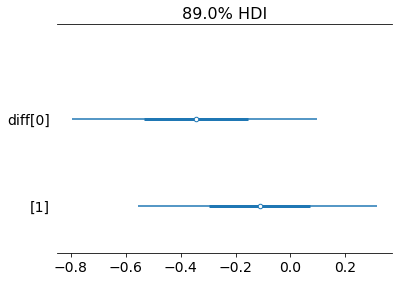

In [38]:
diff = jnp.stack((diff_right, diff_left), axis=-1)
az.plot_forest({"diff": diff}, combined=True, hdi_prob=0.89)

In [33]:
diff.shape

(1, 10000, 2)

In [45]:
dd = d[['actor', 'condition', 'prosoc_left', 'pulled_left']].groupby(['actor', 'condition', 'prosoc_left']).agg(
    num_trials=pd.NamedAgg(column='actor', aggfunc='count'),
    pulled_left=pd.NamedAgg(column='pulled_left', aggfunc='sum'),
).reset_index()
dd[:10]

,actor,condition,prosoc_left,num_trials,pulled_left
0,1,0,0,18,6
1,1,0,1,18,9
2,1,1,0,18,5
3,1,1,1,18,10
4,2,0,0,18,18
5,2,0,1,18,18
6,2,1,0,18,18
7,2,1,1,18,18
8,3,0,0,18,5
9,3,0,1,18,11


In [46]:
def model(actor, condition, prosoc_left, num_trials, pulled_left):
    num_conditions = len(np.unique(condition))
    num_actors = len(np.unique(actor))

    #alpha = numpyro.sample('alpha', dist.Normal(0,1))
    alpha_actor = numpyro.sample('alpha_actor', dist.Normal(0,1.5).expand([num_actors,]))
    beta = numpyro.sample('beta', dist.Normal(0,0.5).expand([num_conditions, 2]))
    l = alpha_actor[actor] + beta[condition, prosoc_left]
    obs = numpyro.sample('obs', dist.BinomialLogits(l, num_trials), obs=pulled_left)


m11_2 = MCMC(NUTS(model), num_warmup=2000, num_samples=10000)
m11_2.run(random.PRNGKey(42), dd.actor.values-1, dd.condition.values, dd.prosoc_left.values, dd.num_trials.values, dd.pulled_left.values)
m11_2.print_summary()

sample: 100%|██████████| 12000/12000 [00:07<00:00, 1676.78it/s, 7 steps of size 4.39e-01. acc. prob=0.90]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_actor[0]     -0.44      0.33     -0.43     -1.01      0.09   3110.04      1.00
alpha_actor[1]      3.90      0.75      3.85      2.66      5.07   8167.88      1.00
alpha_actor[2]     -0.74      0.34     -0.74     -1.27     -0.16   3232.98      1.00
alpha_actor[3]     -0.74      0.34     -0.74     -1.30     -0.18   3207.16      1.00
alpha_actor[4]     -0.44      0.33     -0.44     -0.96      0.13   3057.65      1.00
alpha_actor[5]      0.49      0.33      0.48     -0.07      1.03   3133.99      1.00
alpha_actor[6]      1.97      0.42      1.96      1.25      2.62   4211.10      1.00
     beta[0,0]     -0.05      0.28     -0.05     -0.51      0.43   2686.25      1.00
     beta[0,1]      0.47      0.29      0.47     -0.01      0.93   2686.49      1.00
     beta[1,0]     -0.39      0.29     -0.39     -0.88      0.07   2752.10      1.00
     beta[1,1]      0.36      0.29      0.36     -0.10      0.83

In [58]:
d = pd.read_csv('data/UCBadmit.csv', sep=';')
enc = OrdinalEncoder(dtype=np.int16)
d[['department', 'gender']] = enc.fit_transform(d[['dept', 'applicant.gender']])

In [55]:
d

,dept,applicant.gender,admit,reject,applications,department,gender
1,A,male,512,313,825,0.0,1.0
2,A,female,89,19,108,0.0,0.0
3,B,male,353,207,560,1.0,1.0
4,B,female,17,8,25,1.0,0.0
5,C,male,120,205,325,2.0,1.0
6,C,female,202,391,593,2.0,0.0
7,D,male,138,279,417,3.0,1.0
8,D,female,131,244,375,3.0,0.0
9,E,male,53,138,191,4.0,1.0
10,E,female,94,299,393,4.0,0.0


In [79]:
def model(dept, gender, apps, admits=None):


    alpha_gender = numpyro.sample('alpha_gender', dist.Normal(0,1.5).expand([2,]))
    l = alpha_gender[gender]
    obs = numpyro.sample('obs', dist.BinomialLogits(l, apps), obs=admits)


m11_3 = MCMC(NUTS(model), num_warmup=2000, num_samples=10000)
m11_3.run(random.PRNGKey(42), d.department.values, d.gender.values, d.applications.values, d.admit.values )
m11_3.print_summary()

sample: 100%|██████████| 12000/12000 [00:06<00:00, 1945.58it/s, 7 steps of size 8.15e-01. acc. prob=0.93]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_gender[0]     -0.83      0.05     -0.83     -0.91     -0.75   8116.68      1.00
alpha_gender[1]     -0.22      0.04     -0.22     -0.28     -0.16   7553.61      1.00

Number of divergences: 0


In [60]:
az11_3 = az.from_numpyro(m11_3)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

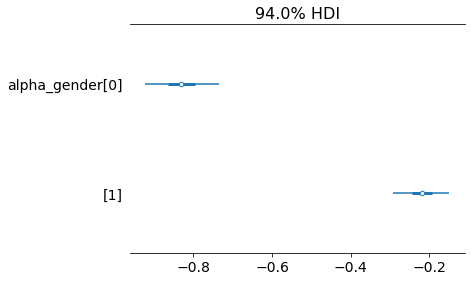

In [65]:
az.plot_forest(az11_3)

In [75]:
post = az11_3['posterior'].stack(sample=("chain", "draw"))
alpha_male = post.alpha_gender[1,:]
alpha_female = post.alpha_gender[0,:]
abs_diff = expit(alpha_male) - expit(alpha_female)
rel_diff = alpha_male - alpha_female


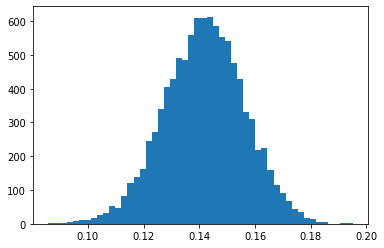

In [77]:
_ = plt.hist(abs_diff, bins=50)

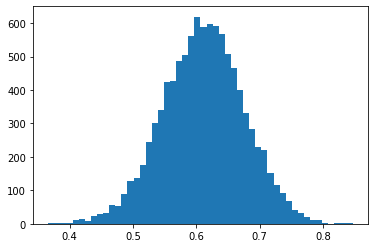

In [78]:
_ = plt.hist(rel_diff, bins=50)

In [89]:
# pred vs actual
post_samples = m11_3.get_samples()
pred = Predictive(model = m11_3.sampler.model, posterior_samples=post_samples)(random.PRNGKey(2), d.department.values, d.gender.values, d.applications.values)['obs']
admit_rate = pred / d.applications.values

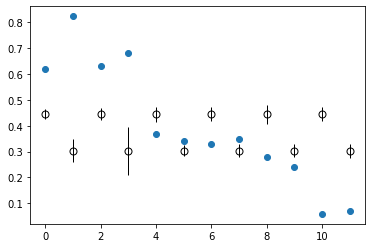

In [93]:
plt.errorbar(range(12), admit_rate.mean(axis=0), admit_rate.std(axis=0), fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,)
plt.scatter(range(12), d.admit/d.applications)

In [104]:
dept_id = jnp.repeat(jnp.arange(6), 2)
dept_id
len(jnp.unique(dept_id))

6

In [109]:
def model(dept, gender, apps, admits=None):

    alpha_gender = numpyro.sample('alpha_gender', dist.Normal(0,1.5).expand([2]))
    alpha_dept = numpyro.sample('alpha_dept', dist.Normal(0,1.5).expand([6]))
    l = alpha_gender[gender] + alpha_dept[dept]
    obs = numpyro.sample('obs', dist.BinomialLogits(l, apps), obs=admits)
    
m11_3 = MCMC(NUTS(model), num_warmup=2000, num_samples=10000)
m11_3.run(random.PRNGKey(42), dept_id, d.gender.values, d.applications.values, d.admit.values )
m11_3.print_summary()


sample: 100%|██████████| 12000/12000 [00:05<00:00, 2163.10it/s, 79 steps of size 6.12e-02. acc. prob=0.90]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha_dept[0]      1.09      0.54      1.10      0.19      1.98    795.64      1.00
  alpha_dept[1]      1.04      0.54      1.05      0.16      1.94    801.46      1.00
  alpha_dept[2]     -0.17      0.54     -0.17     -1.05      0.74    794.28      1.00
  alpha_dept[3]     -0.21      0.54     -0.20     -1.08      0.69    788.45      1.00
  alpha_dept[4]     -0.65      0.54     -0.64     -1.55      0.24    795.22      1.00
  alpha_dept[5]     -2.21      0.56     -2.20     -3.12     -1.27    837.96      1.00
alpha_gender[0]     -0.41      0.54     -0.42     -1.31      0.47    789.37      1.00
alpha_gender[1]     -0.51      0.54     -0.52     -1.42      0.36    784.72      1.00

Number of divergences: 0


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

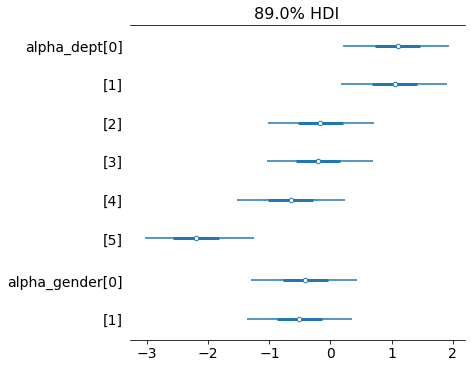

In [112]:
post = m11_3.get_samples()
az.plot_forest(m11_3, hdi_prob=0.89)

In [115]:
d = pd.read_csv('data/Kline.csv', sep=';')

In [123]:
d

,culture,population,contact,total_tools,mean_TU,log_pop,contact_ind
0,Malekula,1100,low,13,3.2,7.003065,1
1,Tikopia,1500,low,22,4.7,7.313220,1
2,Santa Cruz,3600,low,24,4.0,8.188689,1
3,Yap,4791,high,43,5.0,8.474494,0
4,Lau Fiji,7400,high,33,5.0,8.909235,0
5,Trobriand,8000,high,19,4.0,8.987197,0
6,Chuuk,9200,high,40,3.8,9.126959,0
7,Manus,13000,low,28,6.6,9.472705,1
8,Tonga,17500,high,55,5.4,9.769956,0
9,Hawaii,275000,low,71,6.6,12.524526,1


In [122]:
d['log_pop'] = np.log(d['population'])
d['contact_ind'] = enc.fit_transform(d['contact'].values.reshape(-1,1))


In [130]:
def model(contact_ind, log_pop, total_tools=None):

    a_contact = numpyro.sample('a_contact', dist.Normal(3,0.5).expand([2]))
    b_contact_logpop = numpyro.sample('b_logpop', dist.Normal(0,0.2).expand([2]))
    log_expected = a_contact[contact_ind] + b_contact_logpop[contact_ind]*log_pop
    obs = numpyro.sample('obs', dist.Poisson(jnp.exp(log_expected)), obs=total_tools)
    
m11_4 = MCMC(NUTS(model), num_warmup=2000, num_samples=10000)
m11_4.run(random.PRNGKey(42), d.contact_ind.values, d.log_pop.values, d.total_tools.values )
m11_4.print_summary()

sample: 100%|██████████| 12000/12000 [00:05<00:00, 2306.20it/s, 7 steps of size 9.70e-02. acc. prob=0.94] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
a_contact[0]      2.82      0.46      2.83      2.06      3.56   3979.08      1.00
a_contact[1]      1.68      0.29      1.69      1.21      2.14   3831.33      1.00
 b_logpop[0]      0.09      0.05      0.09      0.01      0.17   3925.07      1.00
 b_logpop[1]      0.19      0.03      0.19      0.15      0.24   3807.85      1.00

Number of divergences: 0


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

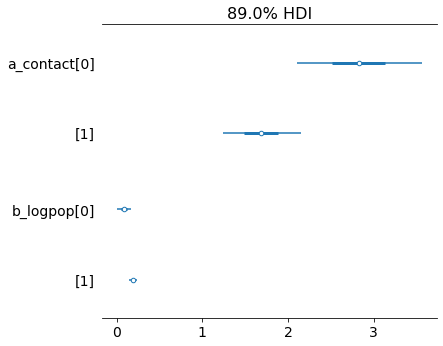

In [132]:
az.plot_forest(m11_4, hdi_prob=0.89)

In [141]:
# check for influential points using WAIC pointwise penalty, which is the variance of the logprobs across the posterier samples for each y datapoint
logprob = log_likelihood(model, m11_4.get_samples(), d.contact_ind.values, d.log_pop.values, d.total_tools.values )["obs"]
penalty = logprob.var(axis=0)
np.array([ penalty, d.culture.values ]).T

array([[0.7194029092788696, 'Malekula'],
       [0.024715078994631767, 'Tikopia'],
       [0.05312381684780121, 'Santa Cruz'],
       [0.28341051936149597, 'Yap'],
       [0.12398253381252289, 'Lau Fiji'],
       [1.8382948637008667, 'Trobriand'],
       [0.037042561918497086, 'Chuuk'],
       [0.1950041800737381, 'Manus'],
       [1.538270354270935, 'Tonga'],
       [1.8349541425704956, 'Hawaii']], dtype=object)